# GMM in PCA space of ensemble of reanalysis datasets

In [2]:
from importlib import reload
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as ctp
import seaborn as sns
from sklearn import mixture, decomposition

from latgmm.utils import utenso, preproc, eof, utdata, utstats, metric
import latgmm.geoplot as gpl

plt.style.use("../../paper.mplstyle")

## Load data

In [3]:
datafile = "../../data/reanalysis/monthly/ssta_merged_dataset_1.nc"
normalization = 'zscore'

ds = xr.open_dataset(datafile)

# Normalization
if normalization is not None:
    attributes = {}
    ds_norm = []
    for var in list(ds.data_vars):
        scaler = preproc.Normalizer(method=normalization)
        buff = scaler.fit_transform(ds[var])
        buff.attrs = {'normalizer': scaler}
        ds_norm.append(buff)

    ds = xr.merge(ds_norm) 

### EOF transformation

In [4]:
n_components = 2
sppca = eof.SpatioTemporalPCA(ds, n_components=n_components)
eofs = sppca.get_eofs()
pcs = sppca.get_principal_components()
pcs = pcs.assign_coords(member=('time', ds['member'].data))
print(f"Explained variance: {np.sum(sppca.explained_variance())}")

Explained variance: 0.48557999299068666


### Plot EN/LN events into PC1-PC2 space

/tmp/ipykernel_14937/3410238632.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../output/plots/pcgmm_latent_neutral.png", dpi=300, bbox_inches="tight")
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


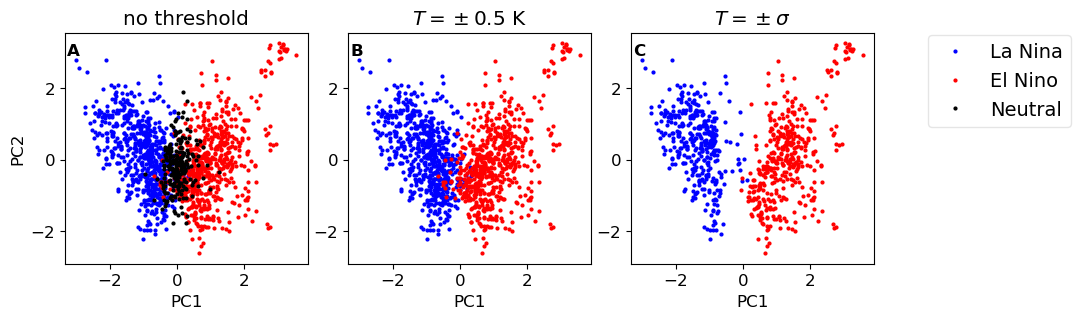

In [18]:
reload(utenso)
import matplotlib.gridspec as gridspec
month_range=[12, 2]

plparam = { 
    'Nino_EP':    dict(linestyle='', marker='.', color='r',markersize=4),
    'Nino_CP':    dict(linestyle='', marker='.', color='r', markersize=4),
    'Nina_CP':    dict(linestyle='', marker='.', color='b', markersize=4),
    'Nina_EP':    dict(linestyle='', marker='.', color='b', markersize=4),
    'Normal':    dict(linestyle='',  marker='.', color='k', markersize=4),
}
labels = {'Nino_EP': 'El Nino', 'Nina_EP': 'La Nina', 'Normal': 'Neutral'}
title = ["no threshold", r'$T = \pm 0.5$ K', r'$T = \pm \sigma$']

fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, width_ratios=[3, 3, 3, 1], wspace=0.2)
axs = [plt.subplot(gs[i]) for i in range(3)]

for i, include_normal in enumerate([True, False]):
    x_enso, x_events = utenso.select_enso_events(ds, month_range=month_range, threshold=0.5,
                                                 include_normal=include_normal)
    z_enso = xr.DataArray(
        data=sppca.transform(x_enso),
        coords={'time': x_enso['time'].data, 'eof': np.arange(1, sppca.n_components+1)}
    ).assign_coords(member=('time', x_enso['member'].data), enso=('time', x_enso['enso'].data))

    for flavor in np.unique(z_enso['enso'].data):
        idx = np.where(z_enso['enso'].data == flavor)[0]
        z = z_enso.isel(time=idx)
        label = labels[flavor] if flavor in labels.keys() else None
        axs[i].plot(z.isel(eof=0), z.isel(eof=1), label=label, **plparam[flavor])
    axs[i].set_xlabel('PC1')
    axs[i].set_title(title[i])


# Std threshold for EN and LN
x_enso, x_events = utenso.select_enso_events(ds, month_range=month_range, threshold='std',
                                             include_normal=False)
z_enso = xr.DataArray(
    data=sppca.transform(x_enso),
    coords={'time': x_enso['time'].data, 'eof': np.arange(1, sppca.n_components+1)}
).assign_coords(member=('time', x_enso['member'].data), enso=('time', x_enso['enso'].data))

for flavor in np.unique(z_enso['enso'].data):
    idx = np.where(z_enso['enso'].data == flavor)[0]
    z = z_enso.isel(time=idx)
    axs[2].plot(z.isel(eof=0), z.isel(eof=1), label=label, **plparam[flavor])

axs[2].set_title(title[2])
axs[2].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
gpl.enumerate_subplots(axs, pos_x=.01, pos_y=.9)

# Axis
ax = plt.subplot(gs[3])
hands, labs = axs[0].get_legend_handles_labels()
ax.legend(hands, labs, bbox_to_anchor=(0.05, .55, 1.3, 1.), loc="lower left", fontsize=14)
ax.axis('off')